# Predicting Heart Disease in Patients with Atypical Angina (ATA) Symptoms


## Introduction
Heart disease is a disease that refers to several types of heart conditions, which is the main cause of death in the USA for most of racial and ethnic groups (1). The main risk factors for heart disease are high blood pressure, high blood cholesterol, smoking, and age. Some of the common heart disease symptoms are chest pain, irregular heartbeats (heart beats too fast or too slow or irregularly), Pain in the back, and shortness of breath. Moreover, chest pain has different classes such as Typical Angina (TA), Atypical Angina (ATA), Non-Anginal Pain (NAP), and Asymptomatic (ASY). Atypical Angina (ATA) chest pain is any chest pain that does not meet criteria for a common or obvious diagnosis (3), and 14% of ATA chest pain leads to heart disease. 

#### Question: 
   Can we use the Age, resting blood pressure (normal blood pressure when body is at rest), maximum heart rate achieved, and blood cholesterol level (provided by the dataset), to predict if a patient with ATA has heart disease? 
   
   To answer this question, we will use the “Heart Failure Prediction Dataset”. This dataset contains 11 variables, which Age, RestingBP, Cholesterol, MaxHR variables will be used to predict the heart disease status (1 = heart disease and 0 = normal). 


## Methods & Results 

In [5]:
### Loading Libraries into R
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)


library(cowplot)
library(GGally)
library(caret)
library(stats)
#set the seed
set.seed(4321)

### 1. Loading the Data
The data was downloaded from Kaggle as a CSV file and was saved to the 'data' folder.

In [6]:
#Reading data from the "data" folder, no data explaination on the csv file, no need for skipping. 
#data is tidy 
#we read the data into R as "data"
set.seed(123)
data <- read_csv("data/heart.csv")
data

Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
40,M,ATA,140,289,0,Normal,172,N,0,Up,0
49,F,NAP,160,180,0,Normal,156,N,1,Flat,1
37,M,ATA,130,283,0,ST,98,N,0,Up,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1
38,M,NAP,138,175,0,Normal,173,N,0.0,Up,0


## Variable Explanation 

Age: age of the patient [years]

Sex: sex of the patient [M: Male, F: Female]

ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

RestingBP: resting blood pressure [mm Hg]
Cholesterol: serum cholesterol [mm/dl]

FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]

MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
ExerciseAngina: exercise-induced angina [Y: Yes, N: No]

Oldpeak: oldpeak = ST [Numeric value measured in depression]

ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

HeartDisease: output class [1: heart disease, 0: Normal]

### Wrangling & Cleaning the Data
The data is tibble and there is no NA found.
We are filtering for ATA chest pain since we are interested in predicting the status of heart disease for patients with this symptom. Selecting for these following numerical variables: 
age, resting blood pressure (mmHg), maximum heart rate, and serum cholesterol level (mm/dl).
HeartDisease was incorrectly stored as a numerical (dbl) column. We use mutate() to turn it into a factor.

In [7]:
  #################check this   
data|>
        filter(HeartDisease==NA)|>
        group_by(HeartDisease)|>
        summarize(n=n())

data|>
        filter(Cholesterol==0)|>
        group_by(Cholesterol)|>
        summarize(n=n())

HeartDisease,n
<dbl>,<int>


Cholesterol,n
<dbl>,<int>
0,172


In [8]:
172 of tye cholsetrol are NA which is saved as 0

ERROR: Error in parse(text = x, srcfile = src): <text>:1:5: unexpected symbol
1: 172 of
        ^


In [9]:
data <- data|> 
    filter(Cholesterol!=0)

data|>
        filter(Cholesterol==0)|>
        group_by(Cholesterol)|>
        summarize(n=n())

Cholesterol,n
<dbl>,<int>


In [10]:
#Convert the character class variable to the factor data type
data_cleaned <- data|>
        mutate(HeartDisease = as.factor(HeartDisease))|>
       # filter(ChestPainType== "ATA")|>
        select(Age, RestingBP, Cholesterol, MaxHR, HeartDisease)
data_cleaned

Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,140,289,172,0
49,160,180,156,1
37,130,283,98,0
⋮,⋮,⋮,⋮,⋮
57,130,131,115,1
57,130,236,174,1
38,138,175,173,0


## Spliting data
spliting the data into training set and testing set, 75% of the data in the training set

In [11]:
### spliting the data into training set and testing set, 75% of the data in the training set
data_split <- initial_split(data_cleaned, prop = 0.75, strata = HeartDisease) 
data_train <- training(data_split)   
data_test <- testing(data_split)
data_train
data_test

Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
37,130,283,98,0
39,120,339,170,0
45,130,237,170,0
⋮,⋮,⋮,⋮,⋮
45,110,264,132,1
68,144,193,141,1
57,130,131,115,1


Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,140,289,172,0
54,150,195,122,0
54,110,208,142,0
⋮,⋮,⋮,⋮,⋮
63,124,197,136,1
59,164,176,90,1
57,130,236,174,1


## Table

In [12]:
na_heart <- data_train|>
        filter(HeartDisease=NA)|>
        group_by(HeartDisease)|>
        summarize(n=n())
na_heart

HeartDisease,n
<fct>,<int>


# explain the mean and why we took it

None of the rows have a missing data within our data set.

In [13]:
nheart <- data_train|>
        group_by(HeartDisease)|>
        summarize(Observation=n())

table_1 <- data_train|>
        group_by(HeartDisease)|>
        summarize(across(Age:MaxHR, mean, na.rm=TRUE)) 
mean_heart_disease <- merge(table_1,nheart) |>
    rename(Avg_Age = Age, Avg_RestingBP = RestingBP, Avg_Cholesterol = Cholesterol, Avg_MaxHR = MaxHR)

#table_2 <- data_train|>
 #       group_by(HeartDisease)|>
  #      summarize(across(Age:MaxHR, max, na.rm=TRUE)) 
#max_heart_disease <- merge(table_2, nheart) |>
 #   rename(max_Age = Age, max_RestingBP = RestingBP, max_Cholesterol = Cholesterol, max_MaxHR = MaxHR) 

#table_3 <- data_train|>
 #       group_by(HeartDisease)|>
  #      summarize(across(Age:MaxHR, min, na.rm=TRUE)) 
#min_heart_disease <- merge(table_3, nheart) |>
 #   rename(min_Age = Age, min_RestingBP = RestingBP, min_Cholesterol = Cholesterol, min_MaxHR = MaxHR)



mean_heart_disease
#max_heart_disease
#min_heart_disease

HeartDisease,Avg_Age,Avg_RestingBP,Avg_Cholesterol,Avg_MaxHR,Observation
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,50.48288,130.1918,243.7740,149.2671,292
1,55.95506,136.3296,250.6742,129.3184,267


# explain the variance and why we took it

In [14]:
table_4 <- data_train|>
        group_by(HeartDisease)|>
        summarize(across(Age:MaxHR, var, na.rm=TRUE)) 
variance_heart_disease <- merge(table_4,nheart) |>
    rename(var_Age = Age, var_RestingBP = RestingBP, var_Cholesterol = Cholesterol, var_MaxHR = MaxHR) 

variance_heart_disease

HeartDisease,var_Age,var_RestingBP,var_Cholesterol,var_MaxHR,Observation
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,93.07531,252.2174,3421.076,528.6500,292
1,77.31376,337.2895,3904.702,466.9547,267


## visalization 

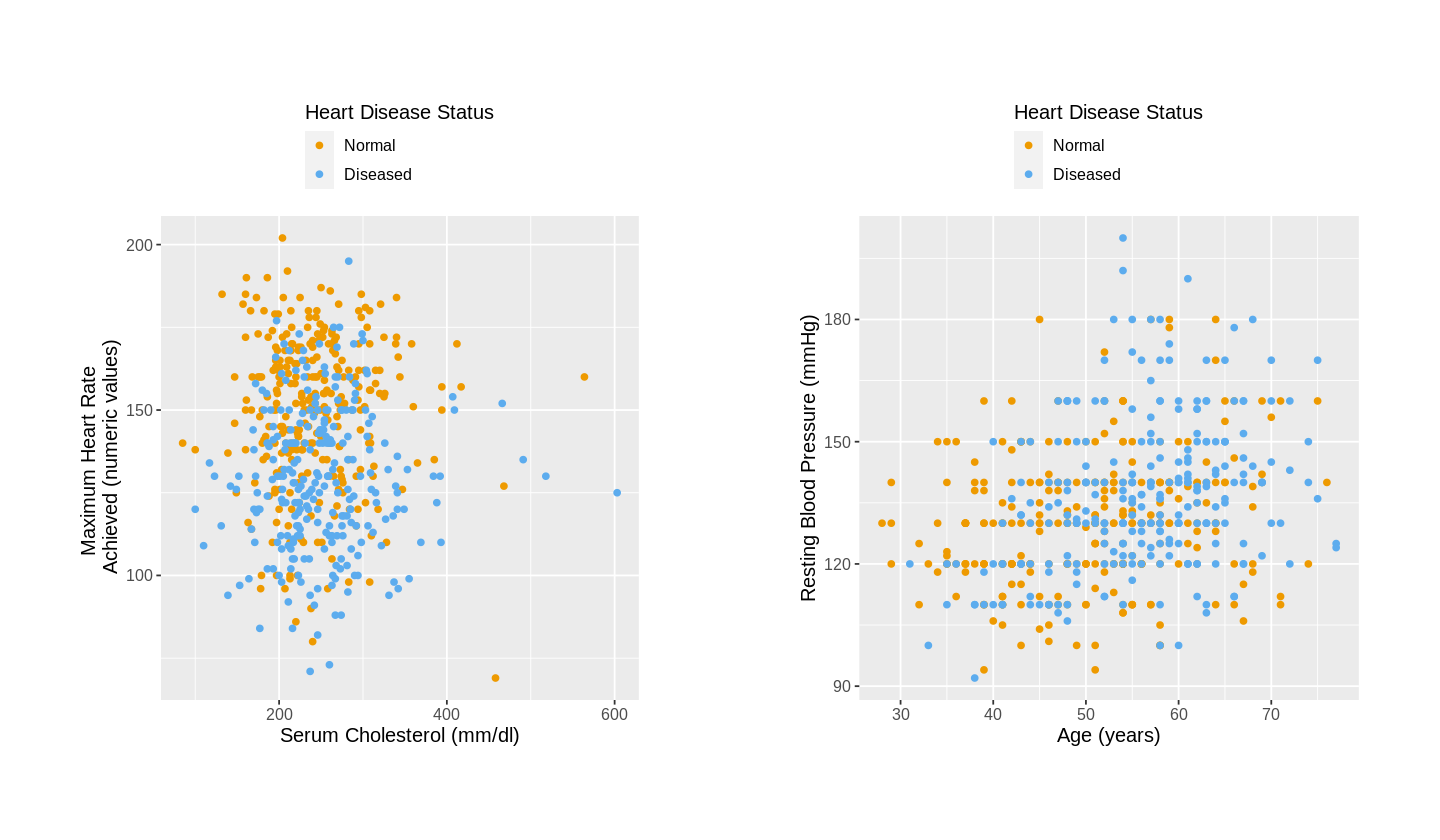

In [15]:
options(repr.plot.width = 12, repr.plot.height = 7) 

#scaterplot resting blood pressure and age 
agevsbp <- ggplot(data_train, aes(x = Age, y = RestingBP, color = HeartDisease)) +
      geom_point() +
      xlab("Age (years)") +
      ylab("Resting Blood Pressure (mmHg)") +
        labs(color= "Heart Disease Status")+
      theme(text = element_text(size = 12),
        legend.position = "top",
        legend.direction = "vertical") +
        scale_color_manual(labels = c("Normal","Diseased"),
                           values= c("orange2","steelblue2"))
      
#agevsbp

#scaterplot cholesterol level and max heart rate
cholvshr <- ggplot(data_train, aes(x = Cholesterol, y = MaxHR, color = HeartDisease)) +
      geom_point() +
      xlab("Serum Cholesterol (mm/dl)") +
      ylab("Maximum Heart Rate \n Achieved (numeric values)") +
labs(color= "Heart Disease Status")+
      theme(text = element_text(size = 12),
        legend.position = "top",
        legend.direction = "vertical") +
        scale_color_manual(labels = c("Normal","Diseased"),
                           values= c("orange2","steelblue2"))

#cholvshr
library(cowplot)
plot_grid(cholvshr, agevsbp, scale=0.8)

In [16]:
describe the data add ggtitle()

ERROR: Error in parse(text = x, srcfile = src): <text>:1:10: unexpected symbol
1: describe the
             ^


# ggtitle
(
label
=
"k-means clustering with 3 clusters"
,
subtitle
=
""
)

## Methods:
  In this project, we are using the “Heart Failure Prediction Dataset” and classification method to predict whether a person with atypical angina (ATA) chest pain has a heart disease or not. The knn classification method will be used because we want to predict heart disease status, which is a (binary) categorical variable, 1= “yes” or 0 = “no”. We will use the numerical variables (predictors) in the dataset including; age (years), resting blood pressure (mmHg), maximum heart rate, and serum cholesterol level (mm/dl) for our prediction as these numerical variables are either the risk factors or symptoms for heart disease. 

We can plot the accuracy versus number of neighbors (k-value) to find the k value with the highest accuracy using a line graph. We can also generate a scatter plot with the scaled and centered age and resting blood pressure on the axis while differentiating the heart disease status with different colors. 

## Expected outcomes and significance:

By developing this model, we expect to be able to predict heart disease accurately based on the biological determinants observed in individuals. This model is particularly significant as it filters for the individuals with ATA chest pain. Chest pain with an atypical angina is not easily diagnosed or classified as a common or obvious condition. Therefore, our model can lay the groundwork for development of models that predict or diagnose heart disease in the patients with atypical pains. Also, in our analysis, some relationships may be observed between heart disease and the predictors. These observations can lead the researchers to answer further questions like what the physiological mechanisms behind these relationships are. Another significant question that will expand this work would be how we can design one model capable of predicting heart disease in individuals with different types of chest pains and across different genders.

In [17]:
theses are notes for myself

ERROR: Error in parse(text = x, srcfile = src): <text>:1:8: unexpected symbol
1: theses are
           ^


In [18]:
#library(themis)

#rep_sample_n

#ups_recipe <- recipe(HeartDisease ~ ., data = data_cleaned) |>
#  step_upsample(HeartDisease, over_ratio = 1, skip = FALSE) |>
#  prep()

#ups_recipe

In [19]:
#upsampled_data <- bake(ups_recipe, data_cleaned)

In [20]:
#sed.seed(4321)
### spliting the data into training set and testing set, 75% of the data in the training set
#data_split <- initial_split(upsampled_data, prop = 0.75, strata = HeartDisease) 
#data_train <- training(data_split)   
#data_test <- testing(data_split)
#data_train
#data_test

In [21]:
#scaterplot resting blood pressure and age 
#agevsbp <- ggplot(data_train, aes(x = Age, y = RestingBP, color = HeartDisease)) +
#      geom_point() +
#      xlab("Age (years)") +
#      ylab("Resting Blood Pressure (mmHg)") +
 #       labs(color= "Heart Disease Status")+
  #    theme(text = element_text(size = 12),
   #     legend.position = "top",
    #    legend.direction = "vertical") +
     #   scale_color_manual(labels = c("Normal","Diseased"),
      #                     values= c("orange2","steelblue2"))
      
#agevsbp

#scaterplot cholesterol level and max heart rate
#cholvshr <- ggplot(data_train, aes(x = Cholesterol, y = MaxHR, color = HeartDisease)) +
 #     geom_point() +
  #    xlab("Serum Cholesterol (mm/dl)") +
   #   ylab("Maximum Heart Rate \n Achieved (numeric values)") +
#labs(color= "Heart Disease Status")+
 #     theme(text = element_text(size = 12),
  #      legend.position = "top",
   #     legend.direction = "vertical") +
    #    scale_color_manual(labels = c("Normal","Diseased"),
     #                      values= c("orange2","steelblue2"))

#cholvshr

#plot_grid(cholvshr, agevsbp, scale=0.8)

### percentage for ATA

In [22]:
n_row <- nrow(data_cleaned)

data_percentage <- data_cleaned |>
    group_by(HeartDisease)|>
    summarize(count=n(), percentage=n()/n_row*100)
data_percentage

n_row_train <- nrow(data_train)

data_train_percentage <- data_train |>
    group_by(HeartDisease)|>
    summarize(count=n(), percentage=n()/n_row_train*100)
data_train_percentage

HeartDisease,count,percentage
<fct>,<int>,<dbl>
0,390,52.27882
1,356,47.72118


HeartDisease,count,percentage
<fct>,<int>,<dbl>
0,292,52.23614
1,267,47.76386


### preprocess data to standardize it

In [23]:
set.seed(123)
data_train_recipe <- recipe(HeartDisease ~ ., data= data_train)|>
    step_scale(all_predictors())|>
    step_center(all_predictors())

data_vfold <- vfold_cv(data_train, v = 10, strata = HeartDisease)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
        set_engine("kknn") |>
        set_mode("classification")

k_vals <- tibble(neighbors= seq(from= 1, to= 40, by= 1))

knn_result <- workflow()|>
    add_recipe(data_train_recipe)|>
    add_model(knn_spec)|>
    tune_grid(resamples=data_vfold, grid=k_vals)|>
    collect_metrics()

accuracies <- knn_result |>
  filter(.metric == "accuracy")

print(accuracies)

# A tibble: 40 × 7
   neighbors .metric  .estimator  mean     n std_err .config              
       <dbl> <chr>    <chr>      <dbl> <int>   <dbl> <chr>                
 1         1 accuracy binary     0.639    10  0.0130 Preprocessor1_Model01
 2         2 accuracy binary     0.639    10  0.0130 Preprocessor1_Model02
 3         3 accuracy binary     0.646    10  0.0143 Preprocessor1_Model03
 4         4 accuracy binary     0.646    10  0.0143 Preprocessor1_Model04
 5         5 accuracy binary     0.662    10  0.0131 Preprocessor1_Model05
 6         6 accuracy binary     0.662    10  0.0131 Preprocessor1_Model06
 7         7 accuracy binary     0.676    10  0.0226 Preprocessor1_Model07
 8         8 accuracy binary     0.676    10  0.0226 Preprocessor1_Model08
 9         9 accuracy binary     0.685    10  0.0222 Preprocessor1_Model09
10        10 accuracy binary     0.685    10  0.0222 Preprocessor1_Model10
# … with 30 more rows


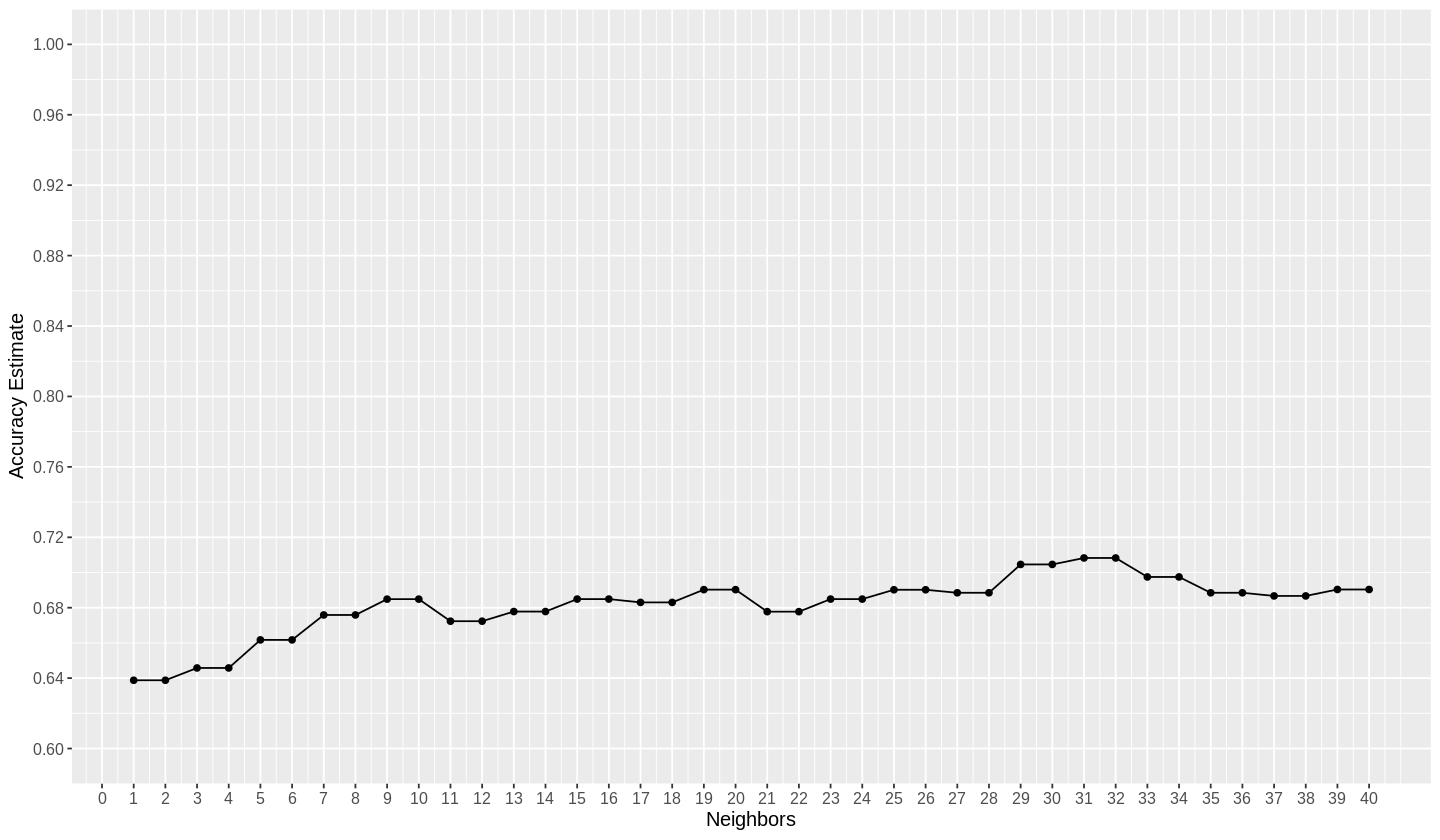

In [24]:
accuracy_vs_k <- ggplot(accuracies, aes(x=neighbors, y=mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 12))+
    scale_x_continuous(breaks = seq(0, 40, by = 1))+  
    scale_y_continuous(limits = c(0.6, 1.0), breaks=seq(0.6, 1, by=0.04))

accuracy_vs_k

In [25]:
talk about wether this is good

ERROR: Error in parse(text = x, srcfile = src): <text>:1:6: unexpected symbol
1: talk about
         ^


In [26]:
maxmax<- accuracies|>
    filter(mean==max(mean))
maxmax

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
31,accuracy,binary,0.7082428,10,0.0121289,Preprocessor1_Model31
32,accuracy,binary,0.7082428,10,0.0121289,Preprocessor1_Model32


In [27]:
explain which k was used

ERROR: Error in parse(text = x, srcfile = src): <text>:1:9: unexpected symbol
1: explain which
            ^


In [30]:
#set.seed(4321)

mnist_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 31) |>
       set_engine("kknn") |>
       set_mode("classification")

mnist_fit <- workflow() |>
            add_recipe(data_train_recipe) |>
            add_model(mnist_spec) |>
            fit(data = data_train)

#mnist_accurate<- mnist_fit|>
 #   collect_metrics()|>
  #          filter(.metric=="accuracy")



#mnist_accurate

In [31]:

mnist_predictions <- predict(mnist_fit, data_test)|>
        bind_cols(data_test)

mnist_predictions

mnist_metrics <- mnist_predictions |>
        metrics(truth=HeartDisease, estimate=.pred_class)

mnist_metrics

mnist_conf_mat <- mnist_predictions |>
        conf_mat(truth = HeartDisease, estimate = .pred_class)

mnist_conf_mat

.pred_class,Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,40,140,289,172,0
1,54,150,195,122,0
0,54,110,208,142,0
⋮,⋮,⋮,⋮,⋮,⋮
1,63,124,197,136,1
1,59,164,176,90,1
0,57,130,236,174,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6737968
kap,binary,0.3423465


          Truth
Prediction  0  1
         0 73 36
         1 25 53

In [33]:
explain the result 
how acccurate our model predict 

ERROR: Error in parse(text = x, srcfile = src): <text>:1:9: unexpected symbol
1: explain the
            ^


In [32]:
question could be how accurate could we predit only with ata chest pain

ERROR: Error in parse(text = x, srcfile = src): <text>:1:10: unexpected symbol
1: question could
             ^


## Refrences
1.Tsao CW, Aday AW, Almarzooq ZI, Beaton AZ, Bittencourt MS, Boehme AK, et al. Heart Disease and Stroke Statistics—2022 Update: A Report From the American Heart Association. Circulation. 2022;145(8):e153–e639.

2.Tsao CW, Aday AW, Almarzooq ZI, Beaton AZ, Bittencourt MS, Boehme AK, et al. Heart Disease and Stroke Statistics—2022 Update: A Report From the American Heart Association. Circulation. 2022;145(8):e153–e639.

3.Centers for Disease Control and Prevention, National Center for Health Statistics. About Multiple Cause of Death, 1999–2020. CDC WONDER Online Database website. Atlanta, GA: Centers for Disease Control and Prevention; 2022. Accessed February 21, 2022.

4.fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved [Date Retrieved] from https://www.kaggle.com/fedesoriano/heart-failure-prediction.
